In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/Pickleapp/20231129')

In [ ]:
X_train = np.load("train_X.npy")
y_train = np.load("train_y.npy")
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
X_test_noaug = np.load("noaug_test_X.npy")
y_test_noaug = np.load("noaug_test_y.npy")
right_X_train = np.load("right_orient_train_X.npy")
right_y_train = np.load("right_orient_train_y.npy")
right_X_test = np.load("right_orient_test_X.npy")
right_y_test = np.load("right_orient_test_y.npy")


In [ ]:
shape = (270, 480, 3)
points = [1,2,3,4,5,6]
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
num_points = len(points) * 2

y_train = y_train[:, point_cols]
y_test = y_test[:, point_cols]
y_test_noaug = y_test_noaug[:, point_cols]
right_y_train = right_y_train[:, point_cols]
right_y_test = right_y_test[:, point_cols]


In [ ]:
bm = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
)
bm.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x.trainable = False
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_points, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten_3 (Flatten)         (None, 276480)            0         
                                                                 
 dropout_3 (Dropout)         (None, 276480)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 3317772 (12.66 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
def average_distance_loss(y_true, y_pred):
    """
    Custom loss function to calculate the average distance between predicted and target coordinates for 6 points.

    Parameters:
    - y_true: Tensor of shape (batch_size, 12), representing the target coordinates.
    - y_pred: Tensor of shape (batch_size, 12), representing the predicted coordinates.

    Returns:
    - loss: Tensor representing the average distance loss.
    """
    # Reshape the tensors to (batch_size, 6, 2) for easy indexing of coordinates
    # print(y_true)
    # print(y_pred)
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))

    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    # print(distances)
    # Calculate the average distance across all coordinates and batches
    loss = tf.reduce_mean(distances)

    return loss

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=average_distance_loss,
                metrics=['mae'])

In [ ]:
print(len(X_train), len(X_test))

1428 372


In [ ]:
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=200, restore_best_weights = True)
np.random.seed(42)
model.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/200
45/45 [==============================] - 18s 307ms/step - loss: 395.9865 - mae: 235.1902 - val_loss: 265.5263 - val_mae: 148.8753
Epoch 2/200
45/45 [==============================] - 12s 278ms/step - loss: 274.4953 - mae: 157.4415 - val_loss: 238.0001 - val_mae: 131.7498
Epoch 3/200
45/45 [==============================] - 12s 277ms/step - loss: 262.9409 - mae: 149.9789 - val_loss: 229.4155 - val_mae: 125.6439
Epoch 4/200
45/45 [==============================] - 12s 274ms/step - loss: 258.5563 - mae: 147.8777 - val_loss: 241.5626 - val_mae: 133.9348
Epoch 5/200
45/45 [==============================] - 12s 276ms/step - loss: 253.5502 - mae: 144.7328 - val_loss: 222.3870 - val_mae: 122.2486
Epoch 6/200
45/45 [==============================] - 12s 277ms/step - loss: 222.3334 - mae: 129.5944 - val_loss: 78.0001 - val_mae: 49.9802
Epoch 7/200
45/45 [==============================] - 12s 276ms/step - loss: 117.5509 - mae: 74.7099 - val_loss: 87.5777 - val_mae: 54.0223
Epoch 8/200

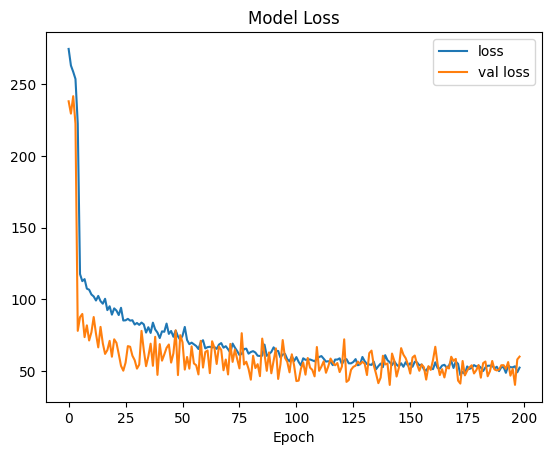

In [ ]:
# plot the history of the loss
start = 1
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss[start:], label="loss")
plt.plot(val_loss[start:], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
# test data
predictions = model.predict(X_test)
mse = np.mean((predictions - y_test)**2)
mae = np.mean(np.abs(predictions - y_test))
print("mse:", mse, "mae:", mae)

12/12 [==============================] - 4s 217ms/step
mse: 2168.7668 mae: 37.22247


In [ ]:
# unaugmented test data
predictions = model.predict(X_test_noaug)
mse = np.mean((predictions - y_test_noaug)**2)
mae = np.mean(np.abs(predictions - y_test_noaug))
print("mse:", mse, "mae:", mae)


4/4 [==============================] - 1s 206ms/step
mse: 1763.1178 mae: 33.69615


In [ ]:
# training
X = X_train
y = y_train
predictions = model.predict(X)
mse = np.mean((predictions - y)**2)
mae = np.mean(np.abs(predictions - y))
print("mse:", mse, "mae:", mae)

45/45 [==============================] - 9s 211ms/step
mse: 1736.9086 mae: 32.936623


In [ ]:
bm.trainable = True
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten_3 (Flatten)         (None, 276480)            0         
                                                                 
 dropout_3 (Dropout)         (None, 276480)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 26837132 (102.38 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
# save weights
from google.colab import files
filename = 'ResNet50v2_all.h5'
model.save_weights(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>